# Unimodal Slice Sampling Example

### Import Libraries

In [41]:
import numpy as np
import math
from scipy.stats import norm as norm
import matplotlib.pyplot as plt
%matplotlib inline  

### Generate Unimodal Gaussian

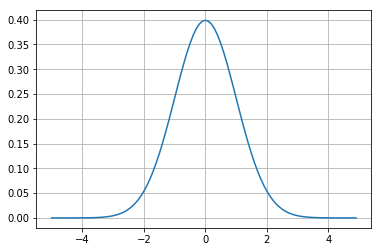

In [42]:
x_low = -5
x_high = 5
x_step = 0.1

X = np.arange(x_low, x_high, x_step)
Y = norm.pdf(X)

plt.plot(X, Y)
plt.grid(True)
plt.show()

### Define function for initial sample for x0

In [43]:
low = X[0] 
high = X[-1]

def sample_x(low=low, high=high):
    x0 = np.random.uniform(low=low, high=high)
    return x0

x0 = sample_x(low, high)

print(x0)

-0.3013123738951977


### Define function for calculating f(x0)

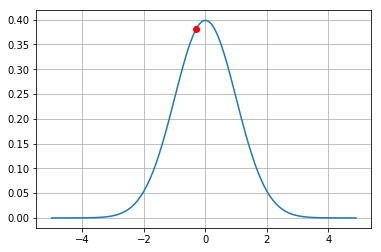

In [44]:
def f_x(x):
    ind = np.argmin(np.abs(X - x))
    f_x0 = Y[ind]
    return f_x0

f_x0 = f_x(x0)

plt.plot(X, Y)
plt.plot([x0], [f_x0], 'ro')
plt.grid(True)
plt.show()

### Define function for sampling in the interval (0, f(x_0)), calculate y

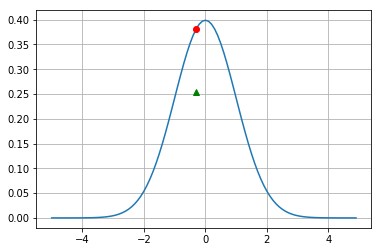

In [50]:
def sample_y(x0, f_x0):
    y = np.random.uniform(low=0, high=f_x0)
    return y

y = sample_y(x0, f_x0)
    
plt.plot(X, Y)
plt.plot([x0], [f_x0], 'ro')
plt.plot([x0], [y], 'g^')
plt.grid(True)
plt.show()


### Define horizontal slice using y

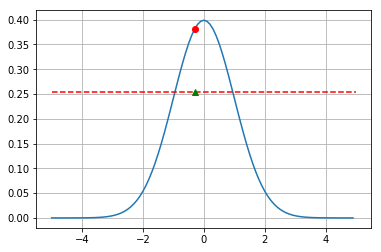

In [51]:
def slice_y(y):
    _x = np.linspace(-5, 5, 50)
    horizontal_line = np.array([y for i in range(len(_x))])   
    return _x, horizontal_line

line = slice_y(y)

plt.plot(X, Y)
plt.plot(line[0], line[1], 'r--')
plt.plot([x0], [f_x0], 'ro')
plt.plot([x0], [y], 'g^')
plt.grid(True)
plt.show()

### Define function for estimating the sampling interval using doubling update

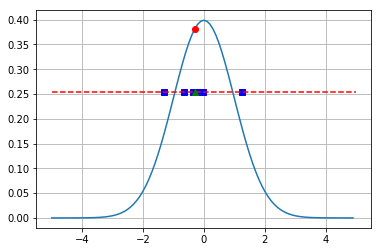

In [52]:
def doubling_update(x0, f_x0, y, w=0.01, p=100):
    u = np.random.uniform()
    l = x0 - w*u
    r = l + w
    k = p
    left = []
    right = []

    while k > 0 and (y < f_x(l) or y < f_x(r)):
        v = np.random.uniform()
        if v < .5:
            l = l - (r-l)
            left.append(l)
        else:
            r = r + (r-l)
            right.append(r)
        k = k-1
    patches = np.concatenate((left,right), axis=None)
    return l, r, patches
    
double = doubling_update(x0, f_x0, y)

ascisse = np.array([y for i in range(len(double[2]))])
plt.plot(double[2],np.array([y for i in range(len(double[2]))]) , 'bs')
plt.plot(X, Y)
plt.plot(line[0], line[1], 'r--')
plt.plot([x0], [f_x0], 'ro')
plt.plot([x0], [y], 'g^')
plt.grid(True)
plt.show()

### Define updating rule for sampling x_n from new interval

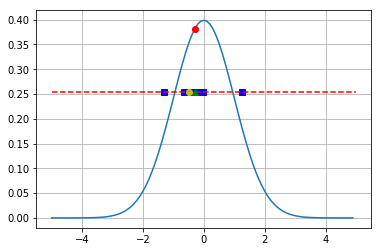

In [53]:
def new_x_double(y, l, r):
    new_x0 = sample_x(l, r)
    while y > f_x(new_x0):
        new_x0 = sample_x(l, r)
    return new_x0

new_double = new_x_double(y, double[0], double[1])

ascisse = np.array([y for i in range(len(double[2]))])
plt.plot(double[2], ascisse, 'bs')
plt.plot(X, Y)
plt.plot(line[0], line[1], 'r--')
plt.plot([x0], [f_x0], 'ro')
plt.plot([x0], [y], 'g^')
plt.plot([new_double], [y], 'yo')
plt.grid(True)
plt.show()

### Sample and plot results

/Users/lorcandelaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/lorcandelaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lorcandelaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


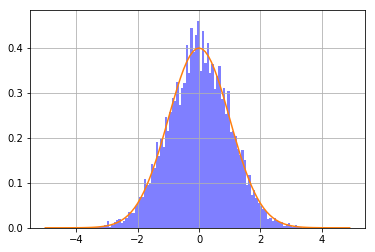

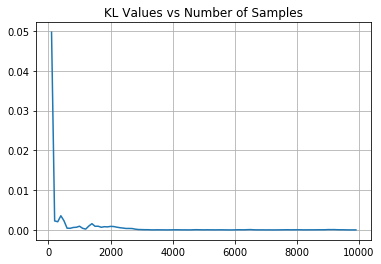

In [54]:
samples_double = []
iterations_d = []
kl_values_d = []
i = 0
l = double[0]
r = double[1]

while i <10000:
    new_x = new_x_double(y, l, r)
    new_fx = f_x(new_x)
    new_sampled_y = sample_y(new_x, new_fx)
    new_double = doubling_update(new_x, new_fx, new_sampled_y)
    samples_double.append(round(new_x,2))
    y = new_sampled_y
    l = new_double[0]
    r = new_double[1]
    if i%100==0:
        (mu_d, sigma_d) = norm.fit(samples_double)
        kl_values_d.append(np.log(sigma_d/1)+((1+(0-mu_d)**2)/(2*sigma_d**2))-.5)
        iterations_d.append(i)
    i = i+1
    
num_bins = 100
n_d, bins_d, patches_d = plt.hist(samples_double, num_bins, facecolor='blue', alpha=0.5, normed=1)
plt.plot(X, Y)
plt.grid(True)
plt.show()

plt.title(r'KL Values vs Number of Samples')
plt.plot(iterations_d, kl_values_d)
plt.grid(True)
plt.show()

### Define Stepout Update function

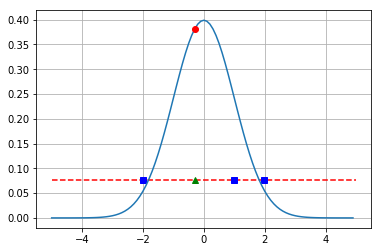

In [55]:
def stepout_update(x0, f_x0, y, w=1, m=40):
    u = np.random.uniform()
    l = x0 - w*u
    r = l + w
    v = np.random.uniform()
    j = math.floor(m*v)
    k = (m-1) - j
    patches = []
    
    while j>0 and y<f_x(l):
        l -= w
        j -= 1
        patches.append(l)
    while k>0 and y<f_x(r):
        r += w
        k -= 1
        patches.append(r)
        
    return l, r, patches
    
    
stepout = stepout_update(x0, f_x0, y)

line = slice_y(y)
plt.plot(line[0], line[1], 'r--')
plt.plot(stepout[2], np.array([y for i in range(len(stepout[2]))]), 'bs')
plt.plot(X, Y)
plt.plot([x0], [f_x0], 'ro')
plt.plot([x0], [y], 'g^')
plt.grid(True)
plt.show()

### Define updating rule for sampling x_n from new interval

1.751343940396867


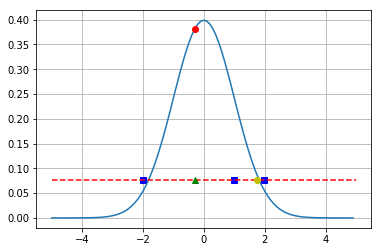

In [56]:
def update_x_stepout(y, l, r):
    new_x = sample_x(l, r)
    while y > f_x(new_x):
        new_x = sample_x(l, r)
    return new_x

new_x_stepout = update_x_stepout(y, stepout[0], stepout[1])
print(new_x_stepout)

plt.plot(stepout[2], np.array([y for i in range(len(stepout[2]))]), 'bs')
plt.plot(X, Y)
plt.plot(line[0], line[1], 'r--')
plt.plot([x0], [f_x0], 'ro')
plt.plot([x0], [y], 'g^')
plt.plot([new_x_stepout], [y], 'yo')
plt.grid(True)
plt.show()

### Sample and plot results and calculate KL Divergence

/Users/lorcandelaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
/Users/lorcandelaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/Users/lorcandelaney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


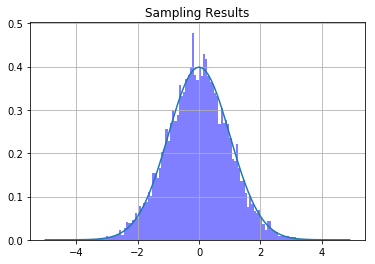

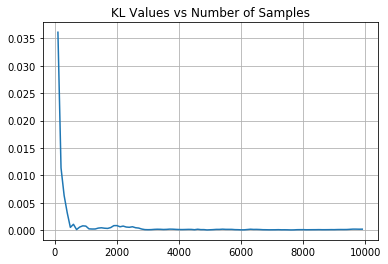

In [59]:
samples_stepout = []
iterations_s = []
kl_values_s = []
i = 0
l = stepout[0]
r = stepout[1]

while i <10000:
    new_x = update_x_stepout(y, l, r)
    new_fx = f_x(new_x)
    new_sampled_y = sample_y(new_x, new_fx)
    new_stepout = stepout_update(new_x, new_fx, new_sampled_y)
    samples_stepout.append(round(new_x,2))
    y = new_sampled_y
    l = new_stepout[0]
    r = new_stepout[1]
    if i%100==0:
        (mu_s, sigma_s) = norm.fit(samples_stepout)
        kl_values_s.append(np.log(sigma_s/1)+((1+(0-mu_s)**2)/(2*sigma_s**2))-.5)
        iterations_s.append(i)
    i = i+1

plt.title(r'Sampling Results')
plt.plot(X, Y)
num_bins = 100
n_s, bins_s, patches_s = plt.hist(samples_stepout, num_bins, facecolor='blue', alpha=0.5, normed=1)
plt.grid(True)
plt.show()

plt.title(r'KL Values vs Number of Samples')
plt.plot(iterations_s, kl_values_s)
plt.grid(True)
plt.show()

### Fit approximate Gaussians to Sample Distributions

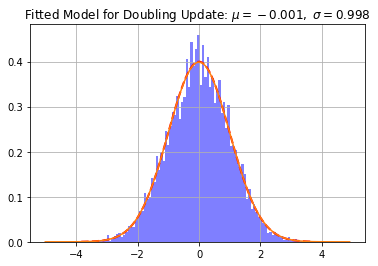

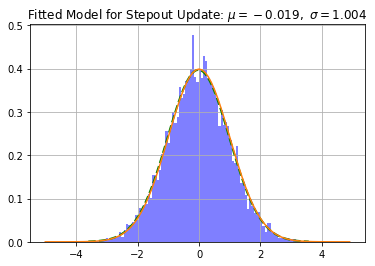

In [62]:
import matplotlib.mlab as mlab

(mu_d, sigma_d) = norm.fit(samples_double)
y_d = mlab.normpdf(bins_d, mu_d, sigma_d)
l_d = plt.plot(bins_d, y_d, 'r--', linewidth=2)

plt.title(r'Fitted Model for Doubling Update: $\mu=%.3f,\ \sigma=%.3f$' %(mu_d, sigma_d))
n_d, bins_d, patches_d = plt.hist(samples_double, num_bins, facecolor='blue', alpha=0.5, normed=1)
plt.plot(X, Y)
plt.grid(True)
plt.show()

(mu_s, sigma_s) = norm.fit(samples_stepout)
y_s = mlab.normpdf(bins_s, mu_s, sigma_s)
l_s = plt.plot(bins_s, y_s, 'g--', linewidth=2)
plt.title(r'Fitted Model for Stepout Update: $\mu=%.3f,\ \sigma=%.3f$' %(mu_s, sigma_s))
n_s, bins_s, patches_s = plt.hist(samples_stepout, num_bins, facecolor='blue', alpha=0.5, normed=1)
plt.plot(X, Y)
plt.grid(True)
plt.show()